#Описание
Данная тетрадка содержит описание данных задачи.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#time_series.csv
Данный файл содержит временные ряды истории обращений к файлам за 78 недель и их метки. Метка **0** - популярные файлы, **1** - непопулярные файлы. Важно надежно определять непопулярные файлы.


###Чтение файла.

In [2]:
lhcb_data = pd.read_csv('/Users/mikhail91/Documents/DataPopularity/Data/popularity-728days.csv')
lhcb_data.irow(range(0,3))

,Name,Configuration,ProcessingPass,FileType,Type,Creation-week,NbLFN,LFNSize,NbDisk,DiskSize,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08-MINBIAS-FIRST-14-NB/Stripping12d,MINIBIAS.DST,1,104591,67,0.317900,134,0.635799,...,12687,12687,12687,12687,12687,12687,12687,12687,12687,12687
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,BHADRON.DST,1,104607,227,0.649204,980,2.819260,...,1631,1631,1631,1631,1631,1631,1631,1631,1631,1631
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,/LHCb/Collision10,/RealData/Reco08/Stripping14,CALIBRATION.DST,1,104607,355,1.370105,355,1.370105,...,0,0,0,474,708,708,708,708,708,708


In [6]:
from datapop.LHCb import DataPreprocessor
data = DataPreprocessor(data=lhcb_data).get_preprocessed_data()
data.irow(range(0,3))

,ID,DiskSize,Creation,First,StartTime,Now,1,2,3,4,...,95,96,97,98,99,100,101,102,103,104
0,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,0.635799,104591,104670,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,134
1,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,2.819260,104607,104676,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,/LHCb/Collision10/Beam3500GeV-VeloClosed-MagDo...,1.370105,104607,104666,104660,104764,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#Отбор данных

In [9]:
selection = data[[str(i) for i in range(21, 53)]]
selected_data = data[selection.sum(axis=1)!=0]

#Препроцессинг данных

In [188]:
X_ts = selected_data[[str(i) for i in range(1+0, 53+0)]].astype(np.float).values
Y_ts = (((selected_data[[str(i) for i in range(53+0, 79+0)]]).sum(axis=1)>0)*1).astype(np.float).values

In [189]:
def add_diff(X):
    X_copy = X.copy()
    for i in range(0,X_copy.shape[1]-1):
        diff = np.array(X_copy[:,i+1] - X_copy[:,i], ndmin=2).T
        X = np.concatenate((X, diff), axis=1)
    return X

def diff(X):
    X_copy = X.copy()
    X_new = None
    for i in range(0,X_copy.shape[1]-1):
        diff = np.array(X_copy[:,i+1] - X_copy[:,i], ndmin=2).T
        if X_new==None:
            X_new=diff
        X_new = np.concatenate((X_new, diff), axis=1)
    return X_new

def sum_window(X, w):
    X_new = None
    i = X.shape[1]
    while i-w >=0:
        wsum = np.array(X[:, range(i-w, i)].sum(axis=1), ndmin=2).T
        i = i - w
        if X_new==None:
            X_new = wsum
        else:
            X_new = np.concatenate((X_new, wsum), axis=1)
    return X_new

def cumsum(X):
    return X.cumsum(axis=1)

In [190]:
X_ts = cumsum(X_ts)

#Картинки

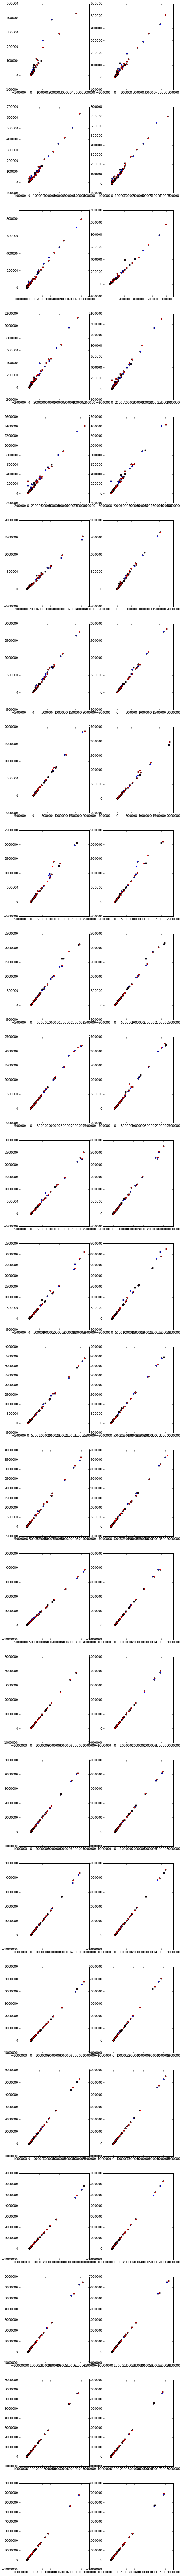

In [191]:
plt.figure(figsize=(9,3*X_ts.shape[1]))
#plt.subplots_adjust( hspace=.5)
for i in range(1, X_ts.shape[1]-1):
    plt.subplot(X_ts.shape[1]//2, 2, i)
    plt.scatter(X_ts[:, i-1], X_ts[:,i], c='b')
    plt.scatter(X_ts[:, i], X_ts[:,i+1], c='r')
plt.show()

#Применение классификатора

In [192]:
from sklearn.cross_validation import KFold

def Indexes_inverse(indexes):
    new_indexes = range(0,len(indexes))
    for i in range(0, len(indexes)):
        new_indexes[int(indexes[i])]=i
    return new_indexes

def KFold_predict_proba(estimator, X, Y, k):
    indexes = np.array([])
    Y_predict_proba = np.empty((0,2))
    kfold = KFold(n=X.shape[0], n_folds=k, random_state=42, shuffle=True)
    for train_index, test_index in kfold:
        X_train, X_test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        #sample_weight = 1. + 1.*Y_train/(Y_train.sum()/float(len(Y_train)-Y_train.sum()))
        indexes = np.concatenate((indexes, test_index), axis=0)
        estimator.fit(X_train, Y_train)
        Y_predict_proba_test = estimator.predict_proba(X_test)
        Y_predict_proba = np.concatenate((Y_predict_proba, Y_predict_proba_test), axis=0)
    new_indexes = Indexes_inverse(indexes)
    return Y_predict_proba[list(new_indexes)]

In [193]:
%%time
from sklearn.grid_search import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

estimator_ts = GradientBoostingClassifier(learning_rate=0.02, n_estimators=2500, max_depth=6, subsample=0.8)
Y_ts_proba = KFold_predict_proba(estimator=estimator_ts, X=X_ts, Y=Y_ts, k=3)

CPU times: user 1min 59s, sys: 248 ms, total: 1min 59s
Wall time: 2min


Значимость признаков

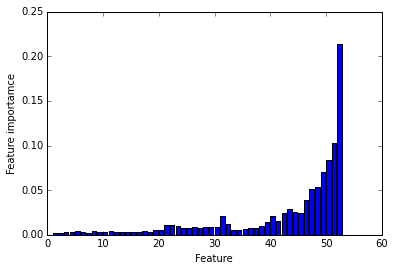

In [194]:
feature_imp = estimator_ts.feature_importances_
plt.bar(range(1,X_ts.shape[1]+1), feature_imp)
plt.xlabel('Feature')
plt.ylabel('Feature importamce')
plt.show()

Строим ROC кривую.

ROC AUC is  0.856970151721


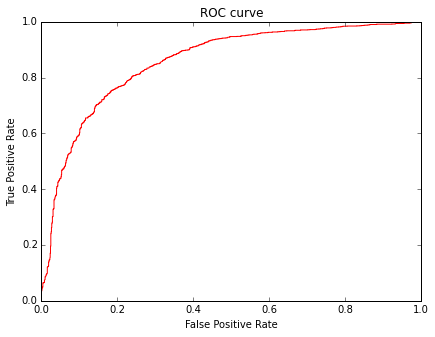

In [195]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts)
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print 'ROC AUC is ', roc_auc_ts

Запишем baseline 1.

In [196]:
# bs1 = pd.DataFrame()
# bs1['fpr_ts'] = fpr_ts
# bs1['tpr_ts'] = tpr_ts
# bs1.to_csv('baseline1.csv')

###Тест на новых данных

###Препроцессинг данных

In [212]:
X_test = selected_data[[str(i) for i in range(1+1, 53+1)]].astype(np.float).values
Y_test = (((selected_data[[str(i) for i in range(53+1, 79+1)]]).sum(axis=1)>0)*1).astype(np.float).values

In [213]:
X_test = cumsum(X_test)

In [214]:
%%time

Y_test_proba = estimator_ts.predict_proba(X_test)

CPU times: user 159 ms, sys: 1.28 ms, total: 160 ms
Wall time: 159 ms


###Сравнение с baselines.

In [215]:
baseline1 = pd.read_csv('baseline1.csv')

ROC AUC is  0.856970151721


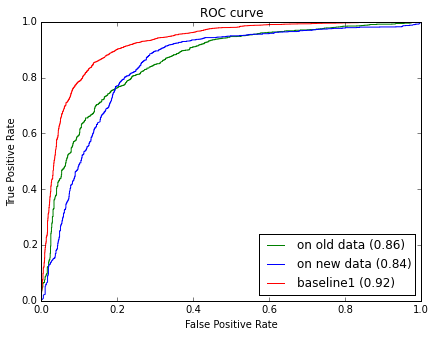

In [216]:
from sklearn.metrics import roc_curve, auc

fpr_ts, tpr_ts, _ = roc_curve(Y_ts, Y_ts_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_ts = auc(fpr_ts, tpr_ts)

fpr_test, tpr_test, _ = roc_curve(Y_test, Y_test_proba[:,1], pos_label=None, sample_weight=None)
roc_auc_test = auc(fpr_test, tpr_test)

roc_auc_base = auc(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(fpr_ts, tpr_ts, label='on old data (%.2f)' % roc_auc_ts, c='g')
plt.plot(fpr_test, tpr_test, label='on new data (%.2f)' % roc_auc_test, c='b')
plt.plot(baseline1['fpr_ts'].values, baseline1['tpr_ts'].values, label='baseline1 (%.2f)' % roc_auc_base, c='r')
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
print 'ROC AUC is ', roc_auc_ts